In [8]:
options(warn = -1)
install.packages('GGally')
install.packages('reshape2')
library(tidyverse)
library(ggplot2)
library(GGally)
library(reshape2)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [12]:
df <- read_csv("df_arabica_clean.csv")
df <- df %>%
  select("Country of Origin","Altitude","Aroma",
         "Flavor","Aftertaste","Acidity","Body","Balance",
         "Uniformity","Clean Cup","Sweetness")
head(df)

New names:
• `` -> `...1`
Rows: 207 Columns: 41
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (22): Country of Origin, Farm Name, Lot Number, Mill, ICO Number, Compan...
dbl (19): ...1, ID, Number of Bags, Aroma, Flavor, Aftertaste, Acidity, Body...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Country of Origin,Altitude,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Colombia,1700-1930,8.58,8.50,8.42,8.58,8.25,8.42,10,10,10
Taiwan,1200,8.50,8.50,7.92,8.00,7.92,8.25,10,10,10
Laos,1300,8.33,8.42,8.08,8.17,7.92,8.17,10,10,10
Costa Rica,1900,8.08,8.17,8.17,8.25,8.17,8.08,10,10,10
Colombia,1850-2100,8.33,8.33,8.08,8.25,7.92,7.92,10,10,10
Guatemala,1668,8.33,8.33,8.25,7.83,7.83,8.17,10,10,10


In [13]:
med <- round(apply(df[,3:8],2,mean),3)
med <- data.frame(med)
sd <- round(apply(df[,3:8],2,sd),3)
med <- cbind(med,Sd = sd)
colnames(med) <- c("Average","Dev")
med

,Average,Dev
,<dbl>,<dbl>
Aroma,7.721,0.288
Flavor,7.745,0.280
Aftertaste,7.600,0.276
Acidity,7.690,0.260
Body,7.641,0.233
Balance,7.644,0.256


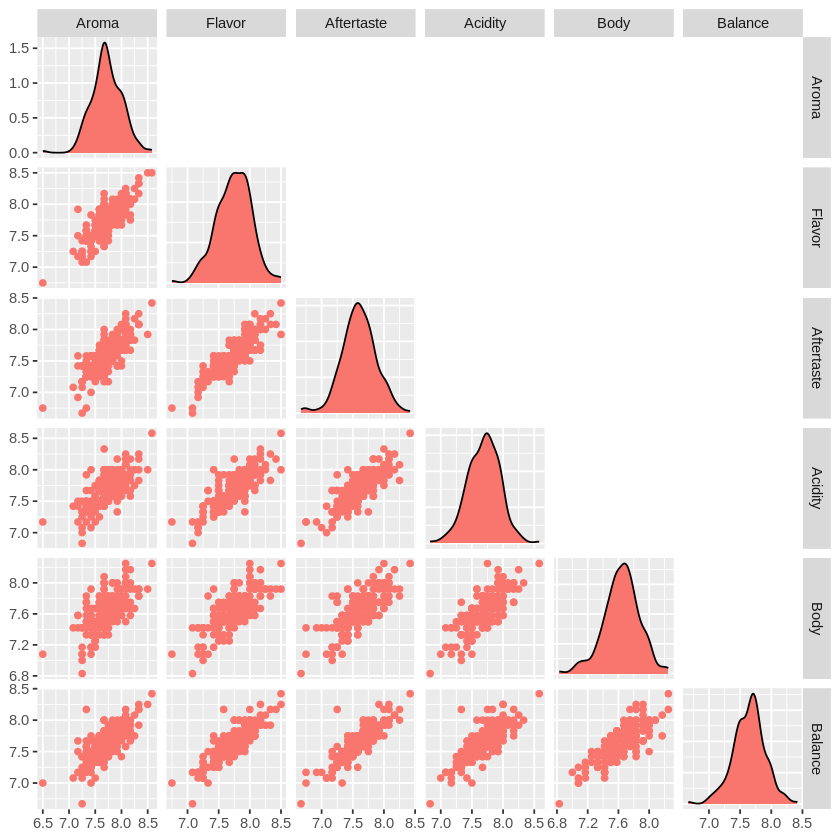

In [14]:
ggpairs(df,columns = 3:8,
        ggplot2::aes(color="blue"),
        upper = "blank")

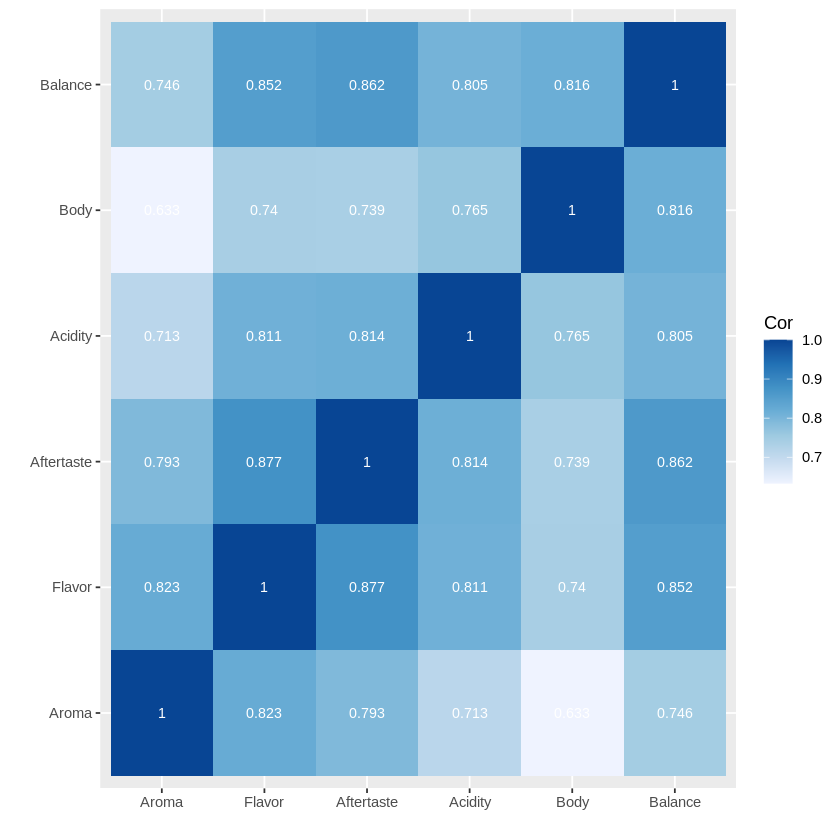

In [15]:
cor <- cor(df[,3:8])
m <- melt(cor)
colnames(m)=c("x","y","Cor")
m$Cor <- round(m$Cor,3)

p <- ggplot(data=m, aes(x,y,
                        fill=Cor)) +
  geom_tile() + geom_text(aes(label=Cor),
                          color='white',size = 3) +
  scale_fill_distiller(direction=1)  +
  labs(x = "", y = "")

p

**The 6 metrics have high correlations with each other, they are all direct relationships, that is, if a coffee receives a high score in any metric, flavor for example, it will also receive high scores in the other metrics.
Due to the high correlations, it is possible to use PCA and perform a more detailed analysis.**

In [16]:
datos_pca <- prcomp(df[,3:8],scale=TRUE)
p <- ncol(df[,3:8])
eigen_datos <- datos_pca$sdev^2
names(eigen_datos) <- paste("PC",1:p,sep="")
sumlambdas <- sum(eigen_datos)
propvar <- eigen_datos/sumlambdas*100
cumvar_datos <- cumsum(propvar)
matlambdas <- rbind(eigen_datos,propvar,cumvar_datos)
round(matlambdas,3)

,PC1,PC2,PC3,PC4,PC5,PC6
eigen_datos,4.936,0.404,0.225,0.196,0.122,0.117
propvar,82.267,6.737,3.750,3.261,2.032,1.952
cumvar_datos,82.267,89.004,92.754,96.015,98.048,100.000


**With 2 principal components it is enough, since with these 89.035% of the total variance are explained. We are going to give these new variables the names Z1 and Z2.**

In [17]:
C.P <- round(datos_pca$rotation,3)
puntajes_pca <- data.frame(datos_pca$x)
PCA <- t(C.P[,1:2])
rownames(PCA) <- c("Z1","Z2")
PCA

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance
Z1,-0.389,-0.423,-0.422,-0.406,-0.387,-0.421
Z2,-0.645,-0.223,-0.150,0.190,0.667,0.174


**Z1, as shown, is negatively charged across all coffee metrics, therefore Z1 can be said to be an assessment of overall coffee quality, i.e. those coffees that score highest across all metrics will have a small value in Z1.
Instead, Z2 is a contrast between aroma, flavor, ftertaste and acidity, body, balance, for example, if a coffee has high values in aroma, flavor, ftertaste and low values in acidity, body, balance, it will have a small value. in Z2, otherwise, it will have a high value in Z2, if the coffee shows a balance in all metrics, it will have a medium value in Z2.**

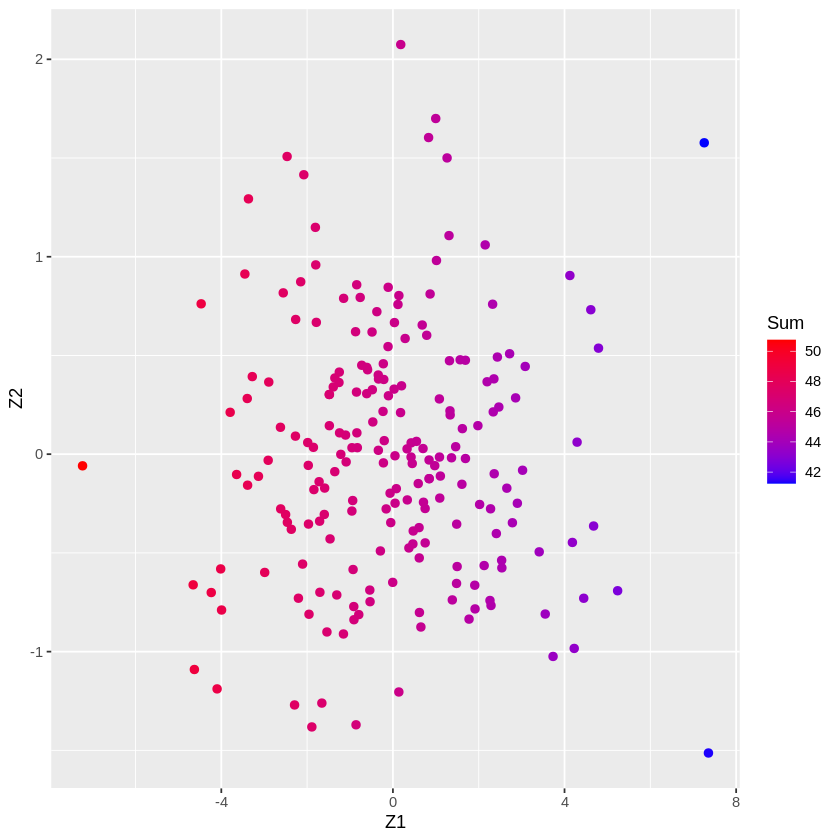

In [18]:
Z <- as.data.frame(datos_pca$x)
Sum <- apply(df[,3:8], 1,sum)
p <- ggplot(data = Z) +
  geom_point(aes(x = PC1,y = PC2,color = Sum),
             size = 2) +
  scale_color_gradient(low = "blue", high = "red") +
  labs(x = "Z1", y = "Z2", color = "Sum")
p

**The scatter diagram shows the aforementioned, since those coffees with the sum of the highest ratings received are the coffees that appear furthest to the left, those points that are at the top of the graph are coffees that have high acidity scores, body and balance.**

## Clustering

**The grouping was done by the ward method, using the 6 original variables.**

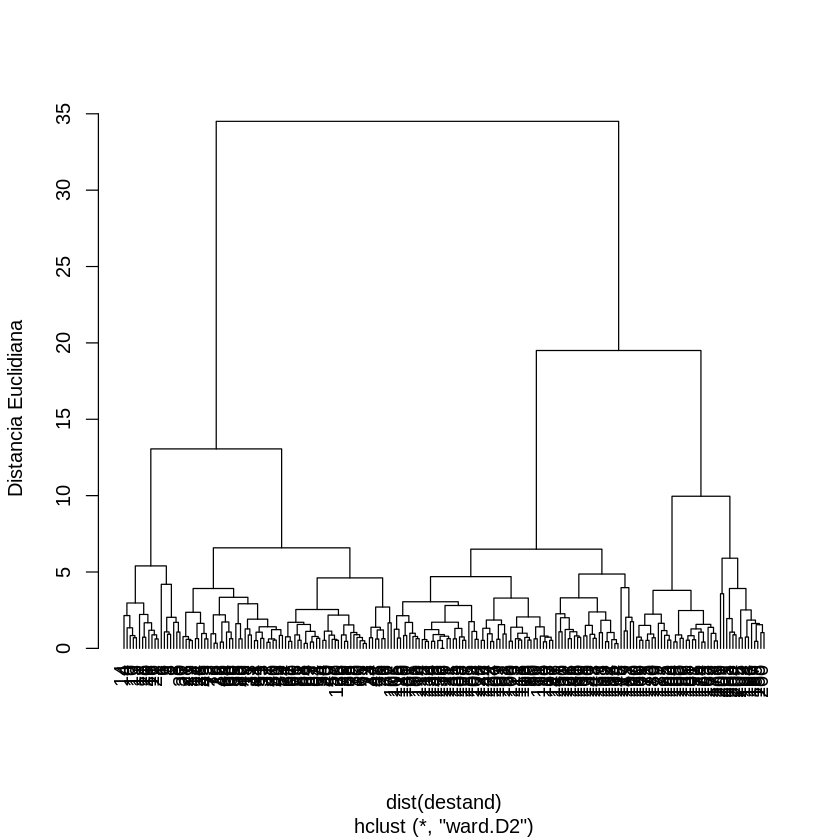

In [19]:
destand = apply(df[,3:8],2,function(x) (x-mean(x))/sd(x))
res = hclust(dist(destand),method= "ward.D2")
plot(res,hang=-1,main="",ylab="Distancia Euclidiana")

**The clustering was done with the original data, the principal components created above can be very useful to describe each of the clusters.**

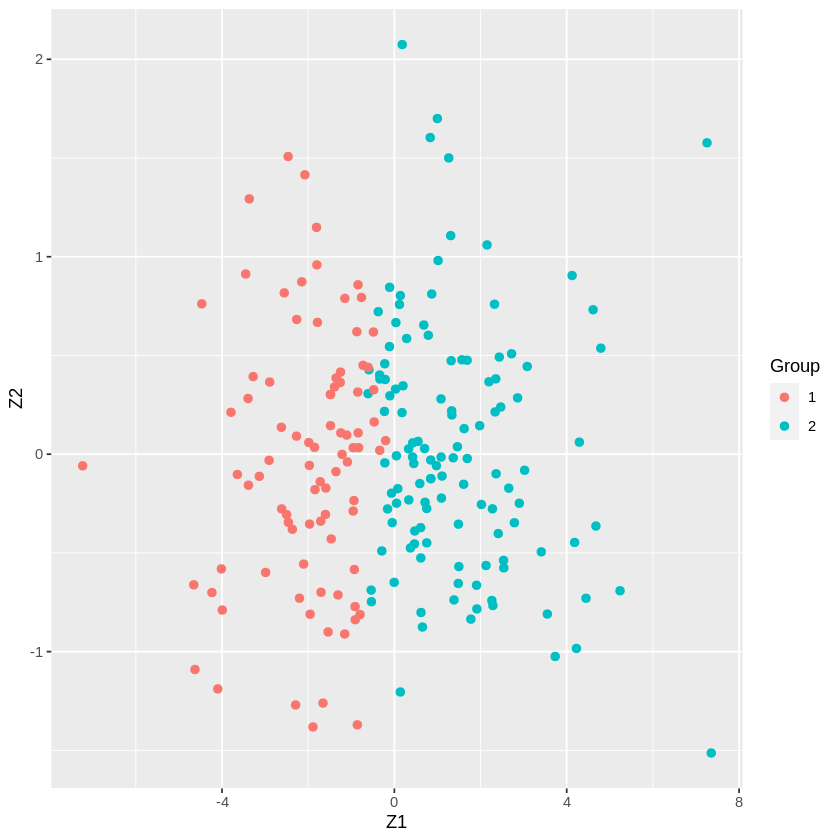

In [20]:
Grupo <- cutree(res,k=2)
ggplot(data = Z) +
  geom_point(aes(x = PC1,y = PC2,color = as.factor(Grupo)),
             size = 2) +
  labs(x = "Z1", y = "Z2", color = "Group")


**As previously stated, those coffees that have small values in Z1 are because they received high scores in all the evaluations. Having said this, it can be seen that group 1 is made up precisely of those coffees that have received the highest scores in all the evaluations. evaluations, so it could be said that they are the highest quality coffees.**

In [21]:
df2 <- cbind(df[,3:8],Grupo)
g1 <- df2 %>% filter(Grupo==1)
data.frame(Promedio = apply(g1, 2,mean))

,Promedio
,<dbl>
Aroma,7.949080
Flavor,7.983793
Aftertaste,7.834368
Acidity,7.902759
Body,7.816322
Balance,7.850690
Grupo,1.000000


In [22]:
g2 <- df2 %>% filter(Grupo==2)
data.frame(Promedio = apply(g2, 2,mean))

,Promedio
,<dbl>
Aroma,7.555750
Flavor,7.571417
Aftertaste,7.429667
Acidity,7.536250
Body,7.513750
Balance,7.494250
Grupo,2.000000
